<a href="https://colab.research.google.com/github/nguyentanphat2210/Bai-/blob/cifar/realtime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Sequential 
from keras.utils import np_utils
from keras.layers import Dense,Activation,Dropout,LSTM,BatchNormalization
from keras.layers import Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

In [13]:
from IPython.display import display, Javascript, Image
# JavaScript to properly create our live video stream using our webcam as input

def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'Bấm vào video để dừng</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [36]:
%cd /content
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import numpy as np
import PIL
import io
import cv2
from keras.models import  load_model

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Đang lấy hình ảnh...'
# initialze bounding box to empty
bbox = ''
count = 0 

# Load model Nhận diện gạo
model_file_path = "/content/gao1.h5"
vggmodel = load_model(model_file_path)

classes = ['gao HUONG MUA ','gao LHR','gao LONGLAI','gao NEPNGONG','gao ST25','gao THOM NHAT','gao THOM SUA','gao Ipsala','gao jasmine','gao An','gao Nhat','gao y','gao luc do', 'gao luc vang','gao tai nguyen']

while True:
    # Đọc ảnh trả về từ JS
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # Resize để đưa vào model
    frame_p = cv2.resize(frame, dsize=(100,100))
    tensor = np.expand_dims(frame_p, axis=0)

    # Feed vào mạng
    pred = vggmodel.predict(tensor)
    class_id = np.argmax((pred))
    class_name = classes[class_id]

    # Vẽ lên một ảnh để tẹo nữa overlay

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
   
    bbox_array = cv2.putText(bbox_array, "{}".format(class_name),
                        (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        (0, 255,0), 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes


/content


<IPython.core.display.Javascript object>

In [14]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

gao THOM NHAT


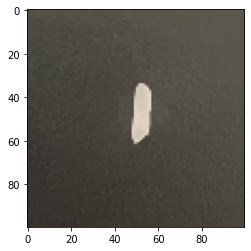

In [30]:
import numpy as np
from tensorflow.keras.utils import load_img,img_to_array
img = load_img('/content/gdrive/MyDrive/AI/Rice test/ThomNhat/THOMNHAT_12.jpg', target_size = (100,100))
plt.imshow(img)
img = img_to_array(img)
img = img.reshape(1,100,100,3) 
img = img.astype('float32')
img = img/255
print(classes[np.argmax(vggmodel.predict(img))])